# 데이터 로더
* [데이터로더 구현](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
* batch기반의 딥러닝 모델 학습을 위해 데이터를 효율적으로 읽어오는 역할

'''

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

'''

In [3]:
from tensorflow import keras
import pandas as pd
import numpy as np

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.csv_path = csv_path
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path) # 데이터프레임화
        
        if self.mode == 'train':
            # 들어온 fold 번호와 다른 fold들을 train 시킴
            self.df = self.df[self.df['fold'] != self.fold] # 다른 걸 df에 넣기
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold] # 같은 folod만 df
            
        self.on_epoch_end()
        
        
    # frac: 전체 row에서 몇 %의 데이터를 return할 것인지를 설정
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # len()
    # ceil() : 올림
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)  

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)

        return batch_x, batch_y

In [5]:
import math
import cv2
import matplotlib.pyplot as plt

In [6]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size=9,
    csv_path = csv_path,
    fold=1,
    image_size=256,
    mode='train',
    shuffle=True
)

In [7]:
print(len(train_generator)) # 미니 배치 하나 사이즈

654


In [8]:
654 * 9 # 총 데이터 개수. 마지막 배치는 654보다 모자름

5886

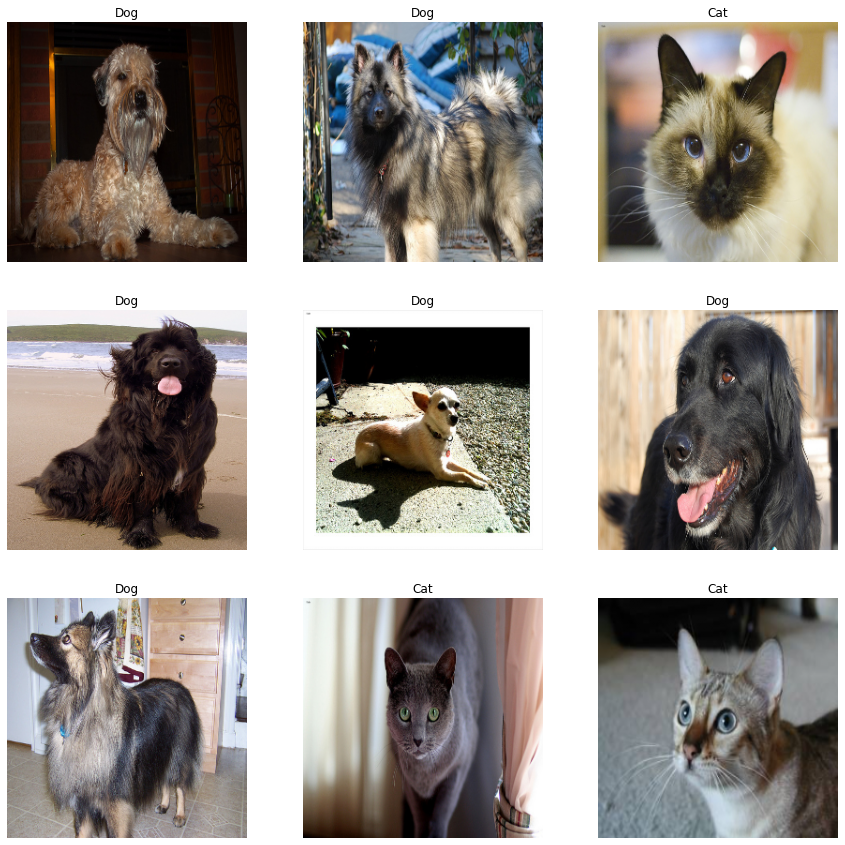

In [10]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
        
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break